## Algoritmo: Gradient Boosting Classifier (GBC) 

En este ejemplo se utiliza el algoritmo de clasificación: **GBC** para predecir si comprar o no comprar una casa.

| Variable       | Tipo             | Descripción                                         |
|----------------|------------------|-----------------------------------------------------|
| ingresos       | numérico entero  | Es el ingreso mensual de una familia                |
| gastos_comunes | numérico entero  | Pagos relacionados con servicios públicos y otros gastos mensuales |
| pago_coche     | numérico entero  | Cuota por pago de un auto y gastos de combustible   |
| gastos_otros   | numérico entero  | Gastos relacionados a compras y lo necesario para el mes |
| ahorros        | numérico entero  | Suma de ahorros dispuestos para comprar la casa     |
| vivienda       | numérico entero  | Precio de la vivienda que se quiere comprar         |
| estado_civil   | numérico entero  | 0-Soltero, 1-Casado, 2-Divorciado                   |
| hijos          | numérico entero  | Número de hijos menores de edad                     |
| trabajo        | numérico entero  | 0-Sin empleo, 1-Independiente, 2-Empleado, 3-Empresario, 4-Pareja: autónomos, 5-Pareja: empleados, 6-Pareja: autónomo y asalariado, 7-Pareja: empresario y autónomo , 8-Pareja: empresarios los dos | 
| comprar        | numérico entero  | 0-No comprar 1-Comprar casa (clase)                        |

### Paso 1: Importar las librerias

In [28]:
# Libreria para operaciones matemáticas o estadísticas
import numpy as np
# Libreria para el manejo de datos
import pandas as pd
# Librerias para gráficas
import matplotlib.pyplot as plt
import seaborn as sb
# Libreria para el balanceo de los datos
from sklearn.utils import resample
# Selección de mejores características con Eli5
from eli5 import show_weights
# Libreria para separar el conjunto de datos en entrenamiento y pruebas
from sklearn.model_selection import train_test_split
# Libreria para Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier
# Librerias para métricas del modelo
from sklearn.metrics import precision_score, recall_score, f1_score
# Libreria para calcular la media y la desviación estándar utilizadas en las características
from sklearn.preprocessing import StandardScaler
# Libreria para menejo de hiperparámetros
from sklearn.model_selection import GridSearchCV

### Paso 2: Cargar el archivo plano en un DataFrame

In [13]:
# Se cargan los datos del archivo plano: 1.6-comprar_alquilar.csv a un DataFrame
df = pd.read_csv("data/1.6-comprar_alquilar.csv")

### Paso 3: Preprocesamiento de los datos

In [14]:
# Se muestran los primeros 10 registros del DataFrame
df.head(10)

,ingresos,gastos_comunes,pago_coche,gastos_otros,ahorros,vivienda,estado_civil,hijos,trabajo,comprar
0,6000,1000,0,600,50000,400000,0,2,2,1
1,6745,944,123,429,43240,636897,1,3,6,0
2,6455,1033,98,795,57463,321779,2,1,8,1
3,7098,1278,15,254,54506,660933,0,0,3,0
4,6167,863,223,520,41512,348932,0,0,3,1
5,5692,911,11,325,50875,360863,1,4,5,1
6,6830,1298,345,309,46761,429812,1,1,5,1
7,6470,1035,39,782,57439,606291,0,0,1,0
8,6251,1250,209,571,50503,291010,0,0,3,1
9,6987,1258,252,245,40611,324098,2,1,7,1


In [15]:
# Se identifican los valores NaN del DataFrame
print("Columna       Cantidad NaN")
print(df.isnull().sum(axis = 0))


Columna       Cantidad NaN
ingresos          0
gastos_comunes    0
pago_coche        0
gastos_otros      0
ahorros           0
vivienda          0
estado_civil      0
hijos             0
trabajo           0
comprar           0
dtype: int64


##### NOTA: Como no hay valores NaN en las columnas, no es necesario aplicar 'dropna()' para eliminarlos

In [16]:
# Se cuentan los registros con valor 0 y 1 (es decir no comprar y comprar la casa)
no_comprar = np.sum(df['comprar'] == 0)
comprar = np.sum(df['comprar'] == 1)

print("No comprar =", no_comprar)
print("Comprar =", comprar)

No comprar = 135
Comprar = 67


In [17]:
# Se genera el balanceo de los datos
df_alto = df[df['comprar'] == 0] # Porque hay 135 registros se define alto
df_bajo = df[df['comprar'] == 1]   # Porque hay 67 registros se define bajo

# Aplicamos undersample para dejar los 67 registros en 135
data_resample_bajo = resample(df_bajo,
                replace = True,
                n_samples = 135,
                random_state = 1)
# Se concatenan (unen) los datos df_alto y los del resample
data = pd.concat([df_alto, data_resample_bajo])
# Se observan la cantidad de registros para 0- No comprar y 1-Comprar casa
data['comprar'].value_counts()

0    135
1    135
Name: comprar, dtype: int64

##### Nota: La técnica de balanceo de datos es buena porque evita el sobre entrenamiento del modelo de predicción.

### Paso 4: Generar las visualizaciones

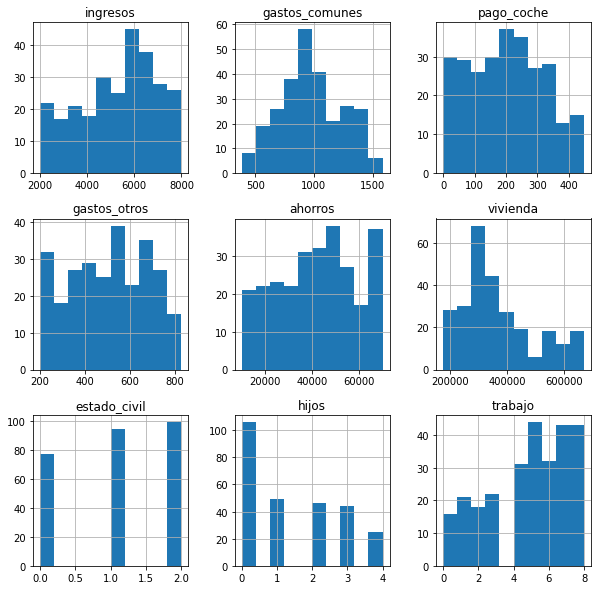

In [18]:
# Se genera el histograma de los datos, pero se excluye la clase (no comprar o comprar)
data.drop(['comprar'], axis=1).hist() # La columna se elimina de manera temporal, es decir solo la gráfica
plt.rcParams['figure.figsize'] = (10, 10)
plt.show()

In [19]:
# Se verifica que todas las columnas están en el DataFrame
data.head()

,ingresos,gastos_comunes,pago_coche,gastos_otros,ahorros,vivienda,estado_civil,hijos,trabajo,comprar
1,6745,944,123,429,43240,636897,1,3,6,0
3,7098,1278,15,254,54506,660933,0,0,3,0
7,6470,1035,39,782,57439,606291,0,0,1,0
10,7273,1455,303,201,39340,577972,0,0,0,0
11,5058,1012,74,463,51836,427334,2,0,2,0


In [20]:
# Se generan las estadísticas del DataFrame
data.describe()

,ingresos,gastos_comunes,pago_coche,gastos_otros,ahorros,vivienda,estado_civil,hijos,trabajo,comprar
count,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000,270.000000
mean,5292.311111,978.348148,202.844444,510.929630,42089.270370,369569.881481,1.081481,1.381481,4.829630,0.500000
std,1638.901727,263.820960,120.497813,172.727342,16900.221776,128613.556428,0.804743,1.381916,2.438967,0.500929
min,2008.000000,384.000000,0.000000,201.000000,10319.000000,176553.000000,0.000000,0.000000,0.000000,0.000000
25%,3997.250000,793.000000,99.000000,367.500000,28503.000000,283936.000000,0.000000,0.000000,3.000000,0.000000
50%,5659.500000,958.000000,199.500000,524.500000,41475.500000,336885.000000,1.000000,1.000000,5.000000,0.500000
75%,6515.000000,1170.250000,291.750000,656.750000,55687.500000,441181.000000,2.000000,3.000000,7.000000,1.000000
max,7984.000000,1585.000000,448.000000,828.000000,69934.000000,669540.000000,2.000000,4.000000,8.000000,1.000000


##### Nota: En count, se observan que los datos están balanceados (135 registros para 0- No comprar y 135 registros para 1-Comprar casa)

### Paso 5: Predicción con el algoritmo Árbol de Decisión

Antes de predecir es necesario
* Se agrupan los diversos gastos (gastos_comunes, gastos_otros, pago coche)
* Se crea una columna denominada financiar, que resta el precio de la vivienda con los ahorros de la familia
* Luego se eliminan las columnas: gastos_comunes, gastos_otros y pago_coche

Luego,
* Seleccionar las mejores características para el modelo de predicción
* Separar los datos de prueba y entrenamiento
* Entrenar el modelo
* Generar la predicción
* Ver las métricas del modelo
* Aplicar los hiperparámentros

In [21]:
# Agrupo los gastos
data['gastos'] = (data['gastos_comunes'] + data['gastos_otros'] + data['pago_coche'])
# Defino financiar
data['financiar'] = (data['vivienda'] - data['ahorros'])
# Elimino las columnas
data = data.drop(['gastos_comunes', 'gastos_otros', 'pago_coche'], axis=1)

# Imprimo las nuevas columnas
data.head(10)

,ingresos,ahorros,vivienda,estado_civil,hijos,trabajo,comprar,gastos,financiar
1,6745,43240,636897,1,3,6,0,1496,593657
3,7098,54506,660933,0,0,3,0,1547,606427
7,6470,57439,606291,0,0,1,0,1856,548852
10,7273,39340,577972,0,0,0,0,1959,538632
11,5058,51836,427334,2,0,2,0,1549,375498
14,7567,42462,641963,2,2,5,0,1739,599501
17,6722,66020,593711,2,2,7,0,1638,527691
18,7705,65410,597411,0,0,2,0,2101,532001
20,6840,50080,455906,2,0,0,0,1279,405826
22,7831,62661,653266,0,0,1,0,1640,590605


In [24]:
# Se seleccionan según su aporte (mayor peso) las mejores características para el modelo de predicción
# Se definen los valores de las características	
features = ['ingresos','ahorros','vivienda','estado_civil','hijos','trabajo','gastos','financiar']
			
# calificación
X = data[features]
# se define la variable objetivo
y = data['comprar'].values

# Se dividen los datos para el entrenamiento (80% entrenamiento y 20% pruebas)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state= 1)

gbc = GradientBoostingClassifier() 
  
# Se entrena el modelo
gbc.fit(X_train, y_train)

pred = gbc.predict(X_test)

# Mejores características - Eli5
show_weights(gbc, feature_names = features)

Weight,Feature
0.3777 ± 0.3181,ingresos
0.2879 ± 0.3263,financiar
0.1708 ± 0.2329,trabajo
0.0976 ± 0.2761,vivienda
0.0319 ± 0.2004,hijos
0.0270 ± 0.4545,ahorros
0.0066 ± 0.1509,gastos
0.0005 ± 0.0734,estado_civil


##### Nota: Se seleccionan: ingresos, financiar y trabajo, porque su peso tiene un mayor aporte para la predicción del modelo.

In [25]:
# Se deja en X todas las características para el modelo
features = ['ingresos','financiar','trabajo','vivienda']
X = data[features]
# Se deja en y la clase (no comprar o comprar) porque es lo que queremos predecir
y = data['comprar'].values

# Dividimos el conjunto de datos en entrenamiento (80%) y pruebas (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=6) 

# Creamos el modelo, lo ponemos a aprender con fit() y obtenemos predicciones sobre nuestro conjunto de test
# Se instancia el clasificador de ensamble
gbc = GradientBoostingClassifier()
# Se entrena el modelo
gbc.fit(X_train, y_train)
# Se genera lapredicción
prediccion = gbc.predict(X_test)
# Métricas clasificación: Precisión, Recall, F1-Score
print("Precisión: ", round(precision_score(y_test, prediccion, average='weighted'), 2))
print("Recall: ", round(recall_score(y_test, prediccion, average='weighted'),2))
print("F1-Score: ", round(f1_score(y_test, prediccion, average='weighted'),2))

Precisión:  0.93
Recall:  0.93
F1-Score:  0.92


##### Nota: Se puede observar que después de balancear los datos y aplicar las otras métricas, el algoritmo árbol de decisión alcanzó 0.92% para la métrica F1 score.

#### Paso 6: Aplicar hiperparámetros

Aquí se aplica la técnica de hiperparámetros para mejorar la precision del modelo

In [31]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Algoritmo GBC
gbc = GradientBoostingClassifier()

# Hiperparámetros
learning_rate = [0.01, 0.05, 0.1, 0.15, 0.2]
criterion = ['friedman_mse', 'squared_error']
max_depth = [3,5,8]
max_features = ['log2','sqrt']

grid = dict(learning_rate = learning_rate,
            criterion = criterion,
            max_depth = max_depth,
            max_features = max_features)

# Técnica de cuadrícula para hiperparámetros
grid_search = GridSearchCV(estimator = gbc, 
                           param_grid = grid, 
                           cv= 10,  
                           verbose=1, 
                           n_jobs=-1,
                           scoring = "accuracy")

searchResults = grid_search.fit(X_train, y_train.ravel())

# Extrae los mejores parámentros para la evaluación del modelo
bestModel = searchResults.best_estimator_

print("Mejores Parámetros (GridSearch):", bestModel)
print("-----------------------------------------------------------")

# Se crea un objeto con los mejores ajustes de Hiperparámetros
gbc = bestModel
  
# Se entrena el modelo con los mejores parámetros
gbc.fit(X_train, y_train)

# predicción con los mejores parámetros
pred = gbc.predict(X_test)

# Métricas clasificación: Precisión, Recall, F1-Score
print("Precisión: ", round(precision_score(y_test, pred, average='weighted'), 2))
print("Recall: ", round(recall_score(y_test, pred, average='weighted'),2))
print("F1-Score: ", round(f1_score(y_test, pred, average='weighted'),2))

Fitting 10 folds for each of 60 candidates, totalling 600 fits


Mejores Parámetros (GridSearch): GradientBoostingClassifier(learning_rate=0.15, max_depth=8, max_features='log2')
-----------------------------------------------------------
Precisión:  0.95
Recall:  0.94
F1-Score:  0.94


##### Nota: La técnica de hiperparámetros permitió que el modelo de predicción mejorara de 0.92% a 0.94% en la métrica F1 score para GBC con los parámetros: learning_rate=0.05, max_depth=8, max_features='sqrt'